C:\Users\conca\Documents\progetti\progettoNLP\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\conca\Documents\progetti\progettoNLP\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 75/75 [07:04<00:00,  5.66s/it]


Train Loss: 0.6703, Val Loss: 0.6038
              precision    recall  f1-score   support

           0       0.94      0.34      0.50        50
           1       0.75      0.99      0.85       100

    accuracy                           0.77       150
   macro avg       0.85      0.67      0.68       150
weighted avg       0.81      0.77      0.74       150



Epoch 2: 100%|██████████| 75/75 [07:22<00:00,  5.89s/it]


Train Loss: 0.3407, Val Loss: 0.9715
              precision    recall  f1-score   support

           0       0.83      0.20      0.32        50
           1       0.71      0.98      0.82       100

    accuracy                           0.72       150
   macro avg       0.77      0.59      0.57       150
weighted avg       0.75      0.72      0.66       150



Epoch 3: 100%|██████████| 75/75 [07:29<00:00,  5.99s/it]


Train Loss: 0.2689, Val Loss: 0.6860
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        50
           1       0.81      0.82      0.82       100

    accuracy                           0.75       150
   macro avg       0.72      0.72      0.72       150
weighted avg       0.75      0.75      0.75       150



Epoch 4: 100%|██████████| 75/75 [07:28<00:00,  5.98s/it]


Train Loss: 0.1700, Val Loss: 0.9895
              precision    recall  f1-score   support

           0       0.57      0.58      0.57        50
           1       0.79      0.78      0.78       100

    accuracy                           0.71       150
   macro avg       0.68      0.68      0.68       150
weighted avg       0.71      0.71      0.71       150



Epoch 5: 100%|██████████| 75/75 [07:26<00:00,  5.95s/it]


Train Loss: 0.1118, Val Loss: 1.4077
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        50
           1       0.81      0.65      0.72       100

    accuracy                           0.67       150
   macro avg       0.66      0.68      0.65       150
weighted avg       0.71      0.67      0.68       150



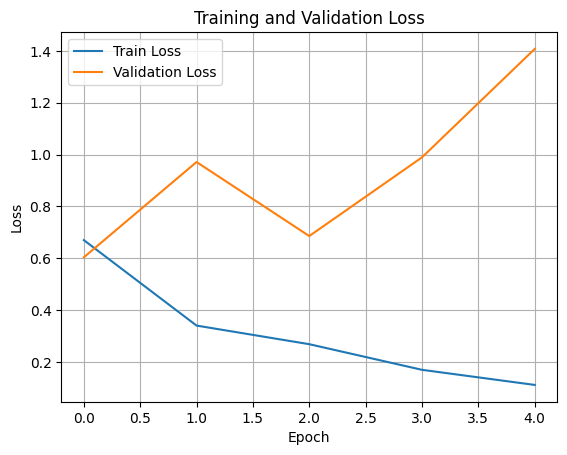


=== TEST EVALUATION ===
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       100
           1       0.81      0.79      0.80       200

    accuracy                           0.74       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.74      0.74      0.74       300

Macro F1-score: 0.7073


In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FUSION_STRATEGY = 1  # 0 = concat, 1 = attention, 2 = cross-modal
CLASSIFIER_TYPE = 1  # 0 = MLP, 1 = Transformer

TRAIN_DATA_DIR = "../pre_processing/dataset/train/"
TRAIN_ANNOTATIONS_PATH = '../pre_processing/dataset/train.json'
VAL_DATA_DIR = "../pre_processing/dataset/val/"
VAL_ANNOTATIONS_PATH = '../pre_processing/dataset/val.json'
TEST_DATA_DIR = "../pre_processing/dataset/test/"
TEST_ANNOTATIONS_PATH = '../pre_processing/dataset/test.json'

LABEL2IDX = {'propagandistic': 1, 'non_propagandistic': 0}

# TEXT ENCODER (BERT)
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")

    def forward(self, texts):
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        outputs = self.bert(**inputs)
        return outputs.last_hidden_state[:, 0, :]  # [CLS] token

# IMAGE ENCODER (ResNet)
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Rimozione del layer full connected

    def forward(self, images):
        feats = self.backbone(images)
        return feats.view(feats.size(0), -1)

# FUSION MODULES
class FeatureFusion(nn.Module):
    def __init__(self, strategy):
        super().__init__()
        self.strategy = strategy
        if strategy == 1:  # Attention
            self.img_proj = nn.Linear(2048, 768)
            self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=4, batch_first=True)
        elif strategy == 2:  # Cross-modal Transformer
            self.img_proj = nn.Linear(2048, 768)
            encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True)
            self.cross_transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, img_feat, txt_feat):
        if self.strategy == 0:
            return torch.cat([img_feat, txt_feat], dim=1)
        elif self.strategy == 1:
            img_proj = self.img_proj(img_feat)
            x = torch.stack([img_proj, txt_feat], dim=1)
            attn_output, _ = self.attn(x, x, x)
            return attn_output.mean(dim=1)
        elif self.strategy == 2:
            img_proj = self.img_proj(img_feat)
            x = torch.stack([img_proj, txt_feat], dim=1)
            x = self.cross_transformer(x)
            return x.mean(dim=1)
        else:
            raise ValueError("Unknown fusion strategy")

# CLASSIFIERS
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 2)  # Classificazione binaria
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.classifier(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=8, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 4, 1)  # Dummy sequence di lunghezza 4 per replicare
        x = self.encoder(x)
        return self.fc(x[:, 0, :])

# MAIN MODEL
class MultimodalClassifier(nn.Module):
    def __init__(self, fusion_strategy=0, classifier_type=0):
        super().__init__()
        self.text_encoder = TextEncoder().to(DEVICE)
        self.image_encoder = ImageEncoder().to(DEVICE)
        self.fusion = FeatureFusion(fusion_strategy).to(DEVICE)

        input_dim = 768 + 2048 if fusion_strategy == 0 else 768

        if classifier_type == 0:
            self.classifier = MLPClassifier(input_dim).to(DEVICE)
        else:
            self.classifier = TransformerClassifier(input_dim).to(DEVICE)

    def forward(self, images, texts):
        txt_feat = self.text_encoder(texts)
        img_feat = self.image_encoder(images)
        fused = self.fusion(img_feat, txt_feat)
        return self.classifier(fused)

# IMAGE TRANSFORM
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MultimodalDataset(Dataset):
    def __init__(self, annotations_path, image_dir):
        with open(annotations_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        filename = entry['image']
        text = entry['text']

        for label_str in LABEL2IDX.keys():
            image_path = os.path.join(self.image_dir, label_str, filename)
            if os.path.exists(image_path):
                label = LABEL2IDX[label_str]
                break
        else:
            raise FileNotFoundError(f"Immagine '{filename}' non trovata in {self.image_dir}")

        image = image_transform(Image.open(image_path).convert("RGB"))
        return image, text, label


def train_model(model, train_loader, val_loader, test_loader, epochs=5, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images, texts)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, texts, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images, texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(classification_report(all_labels, all_preds))

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # TEST EVALUATION
    print("\n=== TEST EVALUATION ===")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, texts, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images, texts)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Macro F1-score: {macro_f1:.4f}")

# DATA LOADER EXAMPLE
train_dataset = MultimodalDataset(TRAIN_ANNOTATIONS_PATH, TRAIN_DATA_DIR)
val_dataset = MultimodalDataset(VAL_ANNOTATIONS_PATH, VAL_DATA_DIR)
test_dataset = MultimodalDataset(TEST_ANNOTATIONS_PATH, TEST_DATA_DIR)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
model = MultimodalClassifier(fusion_strategy=FUSION_STRATEGY, classifier_type=CLASSIFIER_TYPE)
train_model(model, train_loader, val_loader, test_loader)
